# Noise2Void - 2D Example for BSD68 Data

The data used in this notebook is the same as presented in the paper.

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data, autocorrelation
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


# Training Data Preparation

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
dataPath="data/gt.npy"
if not os.path.exists(dataPath):
    _ = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/9LawR2GwE5WGrxw/download', dataPath)
X = np.load(dataPath)

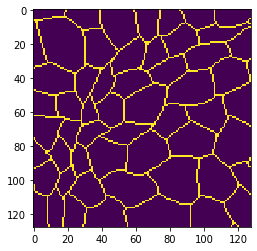

In [3]:
plt.imshow(X[0])

In [4]:
xautocorr = np.array([autocorrelation(_x) for _x in X])

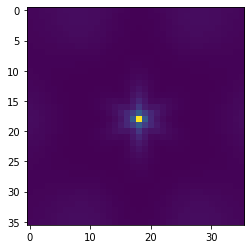

In [5]:
x = xautocorr.mean(0)
def crop_square_center(x,w=20):
    a,b = x.shape
    x = x[a//2-w:a//2+w,b//2-w:b//2+w]
    return x
plt.imshow(crop_square_center(x,18))

## notice faint hexagonal symmetry of cells ?

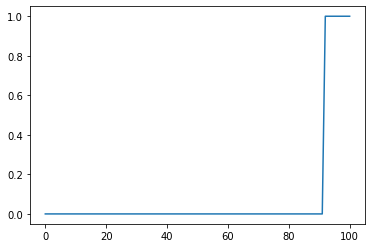

In [6]:
# xs = np.linspace(0,100,101)
# plt.plot(xs,np.percentile(X[:100],xs))

In [7]:
X.shape

(6003, 128, 128)

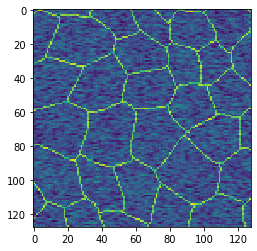

In [8]:
## generate synthetic structured noise

from scipy.ndimage import convolve

purenoise = []
kern  = np.array([[1,1,1]])/3 ## horizontal correlations
a,b,c = X.shape
for i in range(a):
    noise = np.random.rand(b,c)
    noise = convolve(noise,kern)
    purenoise.append(noise)
purenoise = np.array(purenoise)
purenoise = purenoise - purenoise.mean()
    
noisy_dataset = X + purenoise
plt.imshow(noisy_dataset[20])

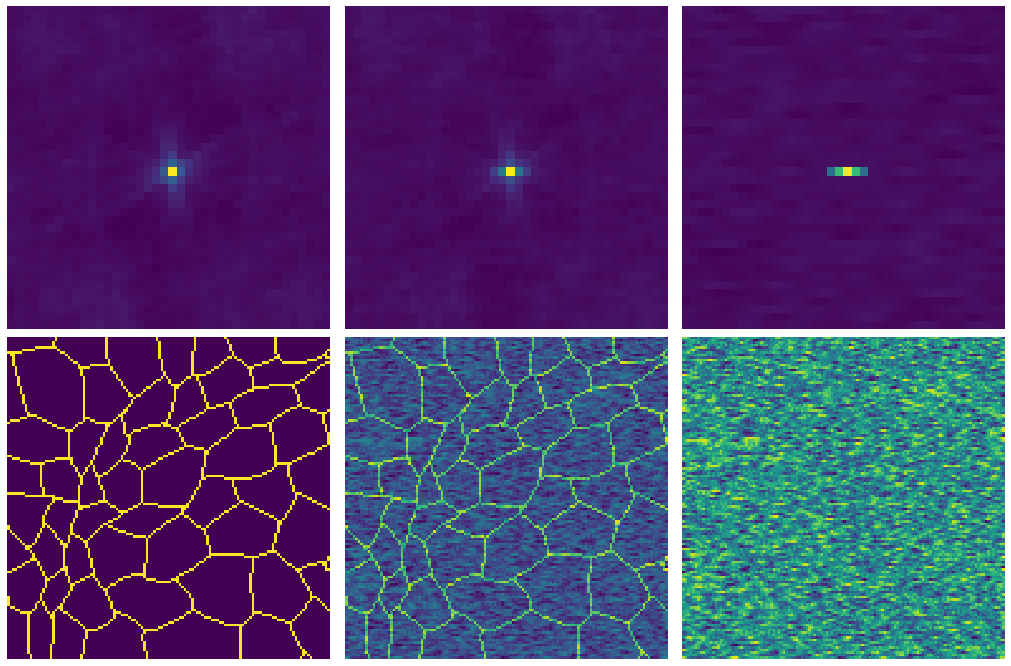

In [9]:
fig,axs = plt.subplots(2,3, gridspec_kw = {'wspace':0.025, 'hspace':0.025}, figsize=(18,12))

def ac_and_crop(x):
    x = autocorrelation(x)
    a,b = x.shape
    x = x[a//2-20:a//2+20, b//2-20:b//2+20]
    return x

x1,x2,x3 = ac_and_crop(X[0]), ac_and_crop(noisy_dataset[0]), ac_and_crop(purenoise[0])
axs[0,0].imshow(x1)
axs[0,1].imshow(x2)
axs[0,2].imshow(x3)
axs[1,0].imshow(X[0])
axs[1,1].imshow(noisy_dataset[0])
axs[1,2].imshow(purenoise[0])

for a in axs.flat: a.axis('off')

In [10]:
inds = np.arange(X.shape[0])
np.random.shuffle(inds)
X_val   = noisy_dataset[inds[:800]][...,None]
X_train = noisy_dataset[inds[800:]][...,None]

# Configure

In [11]:
config = N2VConfig(X_train, unet_kern_size=3, 
                   train_steps_per_epoch=10, train_epochs=10, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   unet_n_first = 96,
                   unet_residual = True,
                   n2v_manipulator='normal_withoutCP', n2v_neighborhood_radius=2,
                   structN2Vmask = [[0,1,1,1,1,1,0]]) ## mask should be wide enough to block most of the noise autocorrelation

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['0.08514151782027725'],
 'stds': ['0.3255333818135192'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 96,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 10,
 'train_steps_per_epoch': 10,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'normal_withoutCP',
 'n2v_neighborhood_radius': 2,
 'structN2Vmask': [[0, 1, 1, 1, 1, 1, 0]],
 'probabilistic': False}

In [12]:
# a name used to identify the model
model_name = 'structn2v_membrane_sim_normal_withoutCP'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)
model.prepare_for_training(metrics=())

config.structN2Vmask [[0, 1, 1, 1, 1, 1, 0]]


# Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [13]:
# We are ready to start training now.
history = model.train(X_train, X_val)

Preparing validation data:   0%|          | 0/800 [00:00<?, ?it/s]

StructN2V Mask is:  [[0 1 1 1 1 1 0]]
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 800/800 [00:01<00:00, 697.95it/s]


Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 1.2934 - val_loss: 1.6818
Epoch 2/10
10/10 [==============================] - 9s 901ms/step - loss: 0.7646 - val_loss: 1.7302
Epoch 3/10
10/10 [==============================] - 7s 725ms/step - loss: 0.6490 - val_loss: 1.0222
Epoch 4/10
10/10 [==============================] - 7s 722ms/step - loss: 0.5699 - val_loss: 1.1290
Epoch 5/10
10/10 [==============================] - 7s 724ms/step - loss: 0.5476 - val_loss: 0.8133
Epoch 6/10
10/10 [==============================] - 7s 728ms/step - loss: 0.5260 - val_loss: 0.6514
Epoch 7/10
10/10 [==============================] - 7s 732ms/step - loss: 0.5008 - val_loss: 0.6671
Epoch 8/10
10/10 [==============================] - 7s 721ms/step - loss: 0.5026 - val_loss: 0.6267
Epoch 9/10
10/10 [==============================] - 7s 731ms/step - loss: 0.5007 - val_loss: 0.5573
Epoch 10/10
10/10 [==============================] - 7s 731ms/step - loss: 0.4756 - val_loss: 0.5400



### After training, lets plot training and validation loss.

['loss', 'lr', 'val_loss']


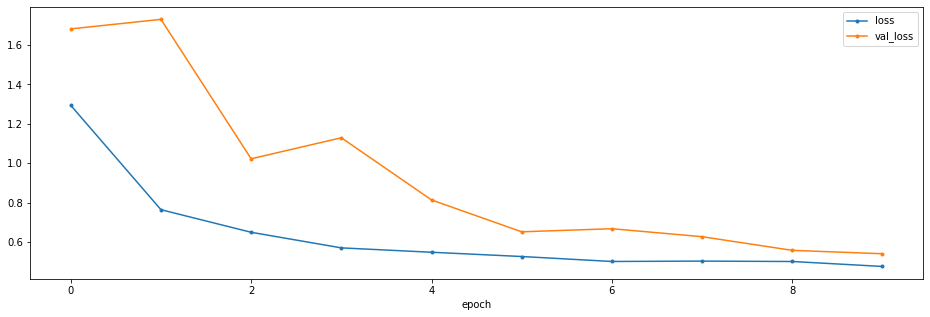

In [15]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# Compute PSNR to GT

In [17]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)

In [26]:
pred = []
psnrs = []
for gt, img in zip(X, noisy_dataset):
    p_ = model.predict(img.astype(np.float32), 'YX');
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)
pred = np.array(pred)

In [38]:
print("PSNR:  {:.3f} {:.3f}".format(psnrs.mean(), psnrs.std()))
print("-------------------")
print("Means: {:.3f} {:.3f} {:.3f}".format(X.mean(),noisy_dataset.mean(),pred.mean()))
print("Stds:  {:.3f} {:.3f} {:.3f}".format(X.std(),noisy_dataset.std(),pred.std()))

PSNR:  62.307 0.765
-------------------
Means: 0.085 0.085 0.112
Stds:  0.279 0.326 0.214


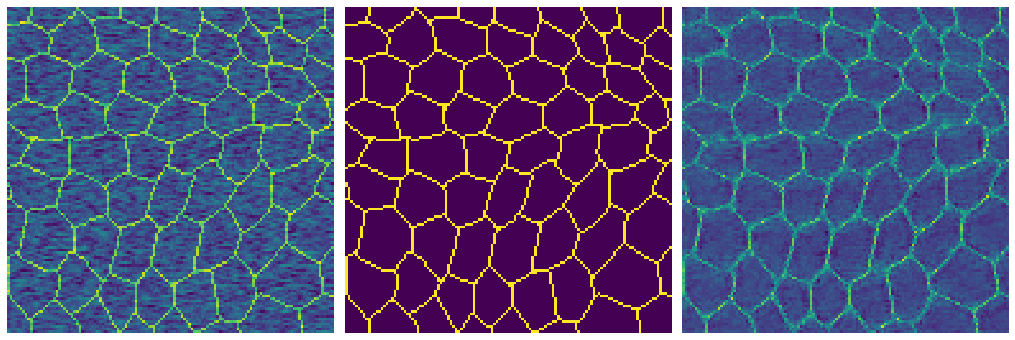

In [39]:
fig,axs = plt.subplots(1,3,figsize=(6*3,6))
axs[0].imshow(noisy_dataset[2], interpolation='nearest')
axs[1].imshow(X[2], interpolation='nearest')
axs[2].imshow(pred[2], interpolation='nearest')

fig.subplots_adjust(wspace=0.025, hspace=0.025)
for a in axs.flat: a.axis('off')